In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# URL to the raw CSV file
url = "https://raw.githubusercontent.com/abdelDebug/Heart-Disease-Data/main/heart_disease.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(url)
print('Shape of the data is ', df.shape)


Shape of the data is  (303, 14)


In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.438944,9.038662,29.0,48.0,56.0,61.0,77.0
sex,303.0,0.679868,0.467299,0.0,0.0,1.0,1.0,1.0
cp,303.0,2.158416,0.960126,0.0,2.0,2.0,3.0,3.0
trestbps,303.0,131.689769,17.599748,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.693069,51.776918,126.0,211.0,241.0,275.0,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.990099,0.994971,0.0,0.0,1.0,2.0,2.0
thalach,303.0,149.607261,22.875003,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [7]:
df.isna().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [8]:
df.duplicated().sum()


0

In [9]:
df.columns


Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [10]:
# #  Handle Missing Values (if any)
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
# df[numeric_features] = df[numeric_features].fillna(df[numeric_features].mean())

# #  Encode Categorical Variables
# categorical_features = ['cp', 'thal', 'slope']
# df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

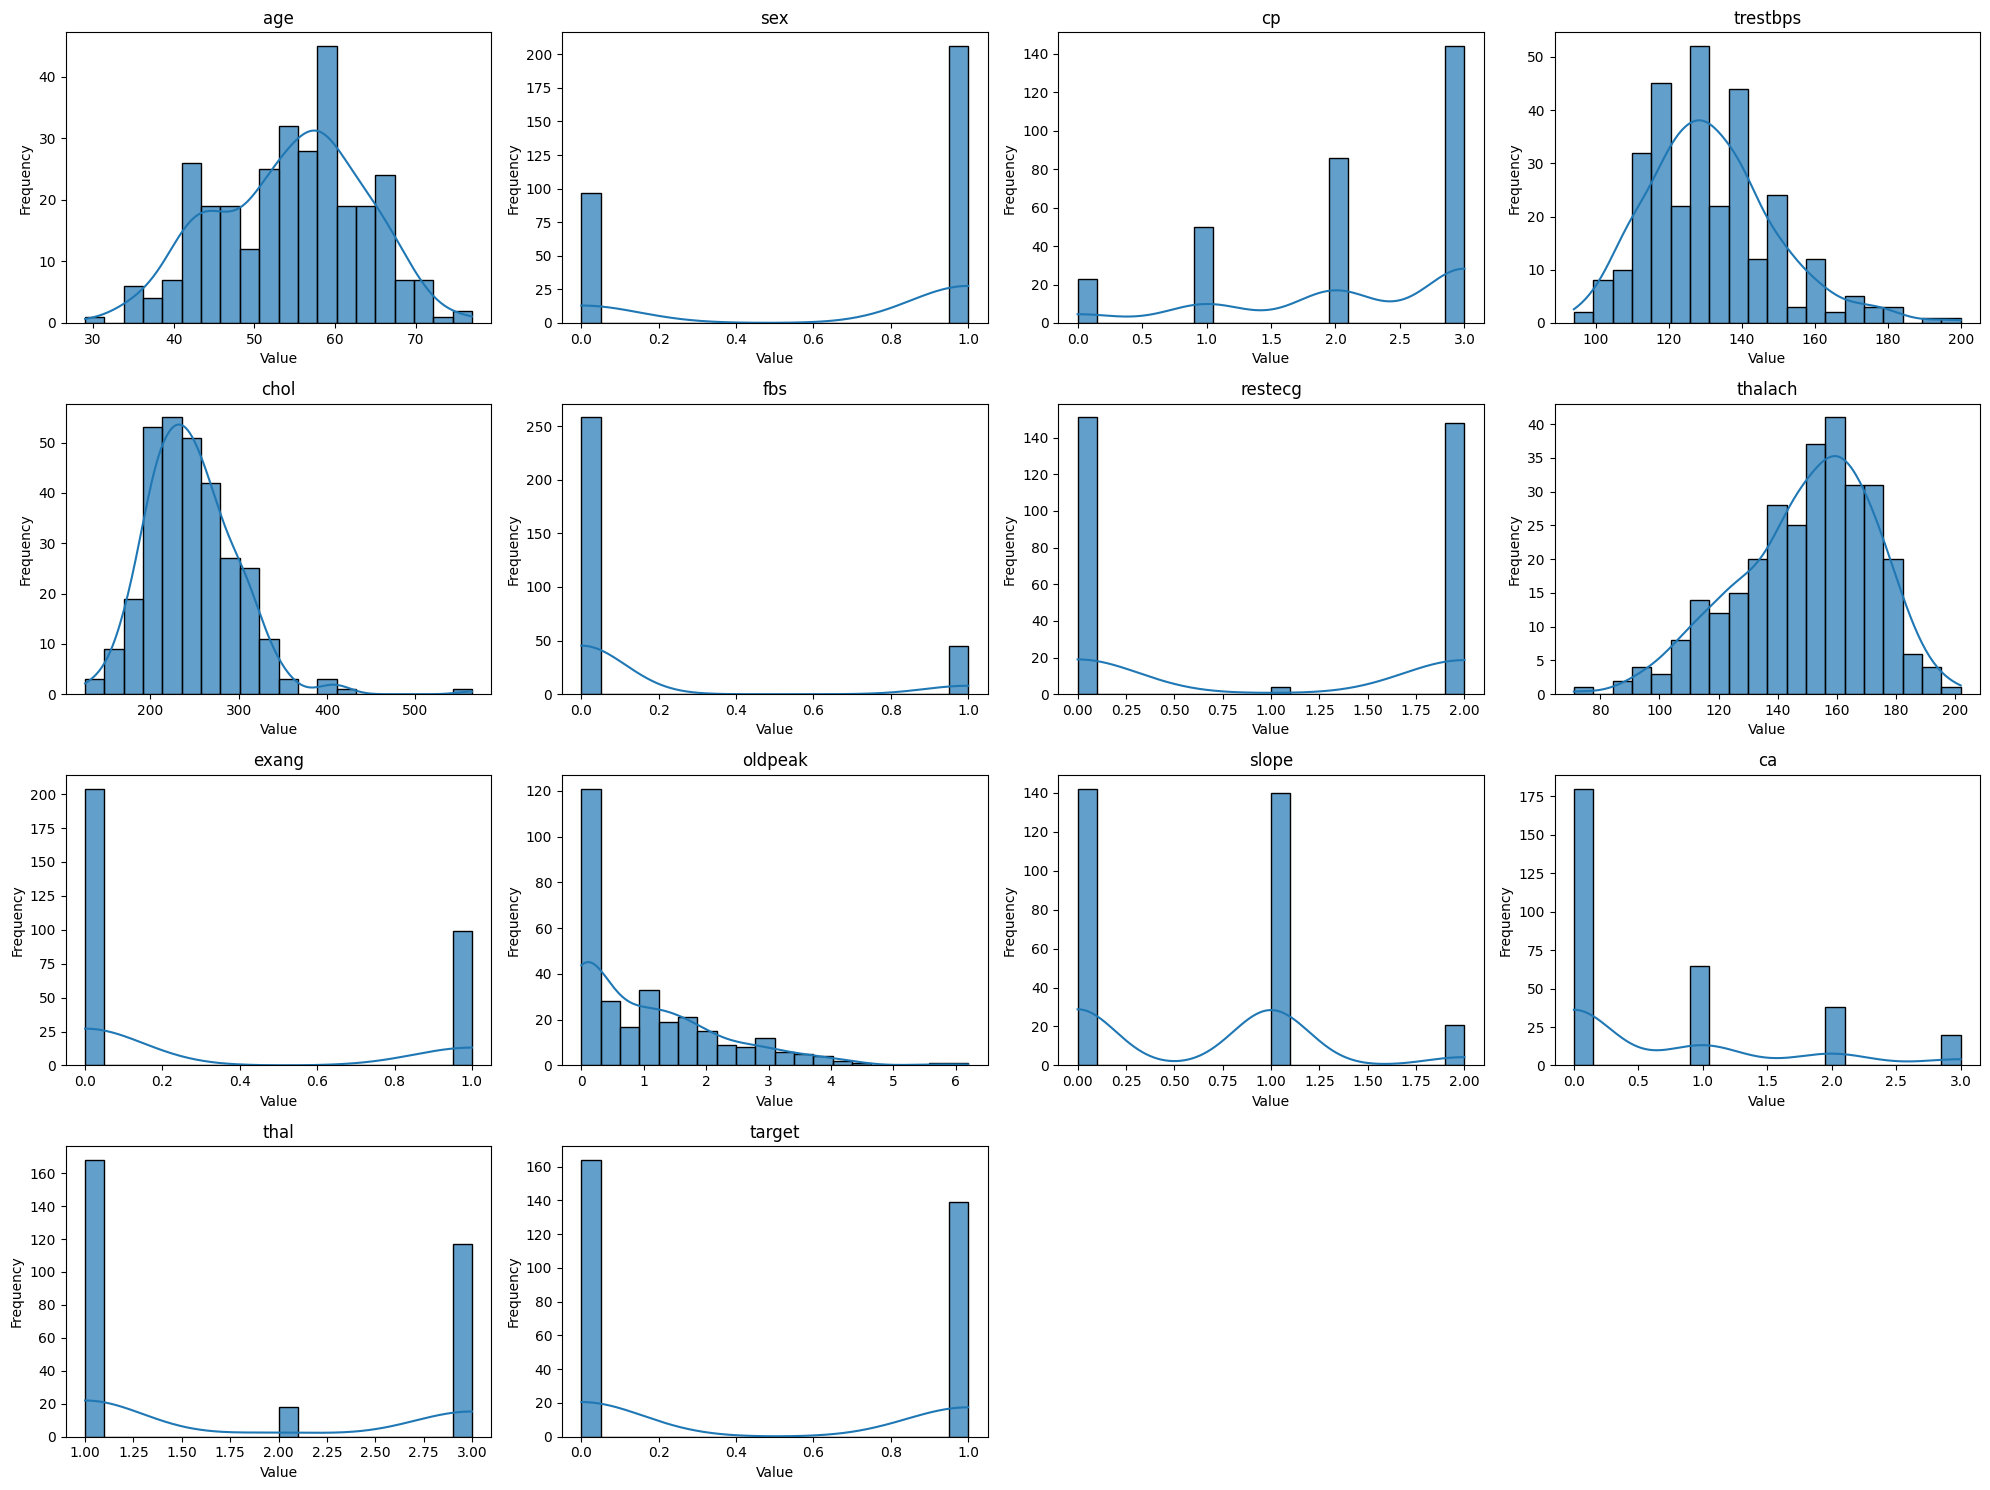

In [11]:

# Set up grid dimensions (4 columns, adjust rows accordingly)
cols = 4
rows = (len(numeric_features) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.ravel()  # Flatten axes array

# Plot histograms
for i, col in enumerate(numeric_features):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i], alpha=0.7, bins=20)
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Turn off unused subplots
for j in range(len(numeric_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [12]:

outlier_data = []
for col in numeric_features:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_below = (df[col] < lower_bound).sum()
        outliers_above = (df[col] > upper_bound).sum()
        total_outliers = outliers_below + outliers_above
        outlier_data.append([col, outliers_below, outliers_above, total_outliers])

outlier_df = pd.DataFrame(outlier_data, columns=['Feature', 'Outliers Below', 'Outliers Above', 'Total Outliers'])
print(outlier_df)


     Feature  Outliers Below  Outliers Above  Total Outliers
0        age               0               0               0
1        sex               0               0               0
2         cp              23               0              23
3   trestbps               0               9               9
4       chol               0               5               5
5        fbs               0              45              45
6    restecg               0               0               0
7    thalach               1               0               1
8      exang               0               0               0
9    oldpeak               0               5               5
10     slope               0               0               0
11        ca               0              20              20
12      thal               0               0               0
13    target               0               0               0


In [13]:
#   Handling Outliers
for column in df.select_dtypes(include=['float64', 'int64']).columns:
  if column not in ('fbs','sex','cp','restecg','exang','slope','ca','thal','target'):
      Q1 = df[column].quantile(0.25)
      Q3 = df[column].quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 -1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [14]:
#   Handle Outliers
# z_thresh = 3
# for col in numeric_features:
#     if col in df.columns:
#         z_scores = (df[col] - df[col].mean()) / df[col].std()
#         df[col] = np.where(z_scores > z_thresh, df[col].mean() + 3 * df[col].std(), df[col])
#         df[col] = np.where(z_scores < -z_thresh, df[col].mean() - 3 * df[col].std(), df[col])

In [15]:
df.shape

(284, 14)

In [16]:
if df['sex'].dtype != 'int64' and df['sex'].dtype != 'int32':
    df['sex'] = (df['sex'] > 0.5).astype(int)

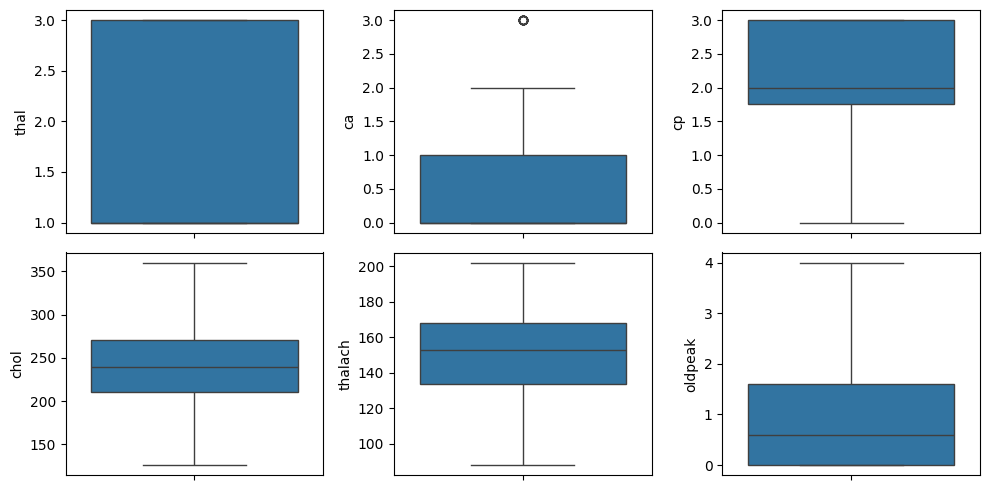

In [17]:
# After applying Outlier removal
fig, axs = plt.subplots(2,3, figsize = (10,5))
plt1 = sns.boxplot(df['thal'], ax = axs[0,0])
plt2 = sns.boxplot(df['ca'], ax = axs[0,1])
plt3 = sns.boxplot(df['cp'], ax = axs[0,2])
plt1 = sns.boxplot(df['chol'], ax = axs[1,0])
plt2 = sns.boxplot(df['thalach'], ax = axs[1,1])
plt3 = sns.boxplot(df['oldpeak'], ax = axs[1,2])

plt.tight_layout()

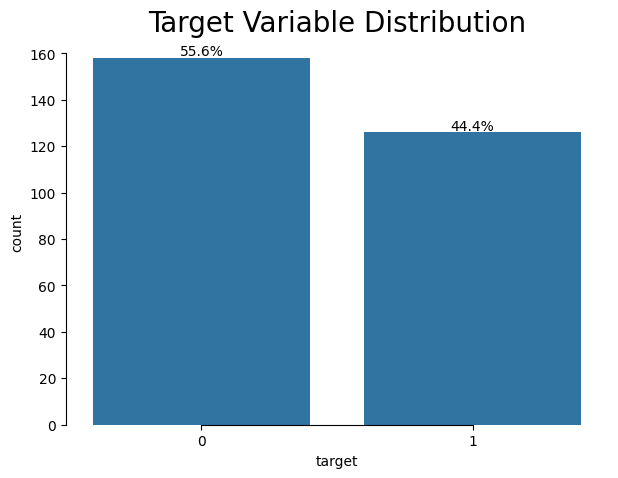

In [18]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(x=df['target'])

# Add percentages directly above bars
total = len(df)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 1,
            f"{p.get_height() / total * 100:.1f}%", ha="center")

plt.title('Target Variable Distribution', fontsize=20)
sns.despine(trim=True)
plt.show()


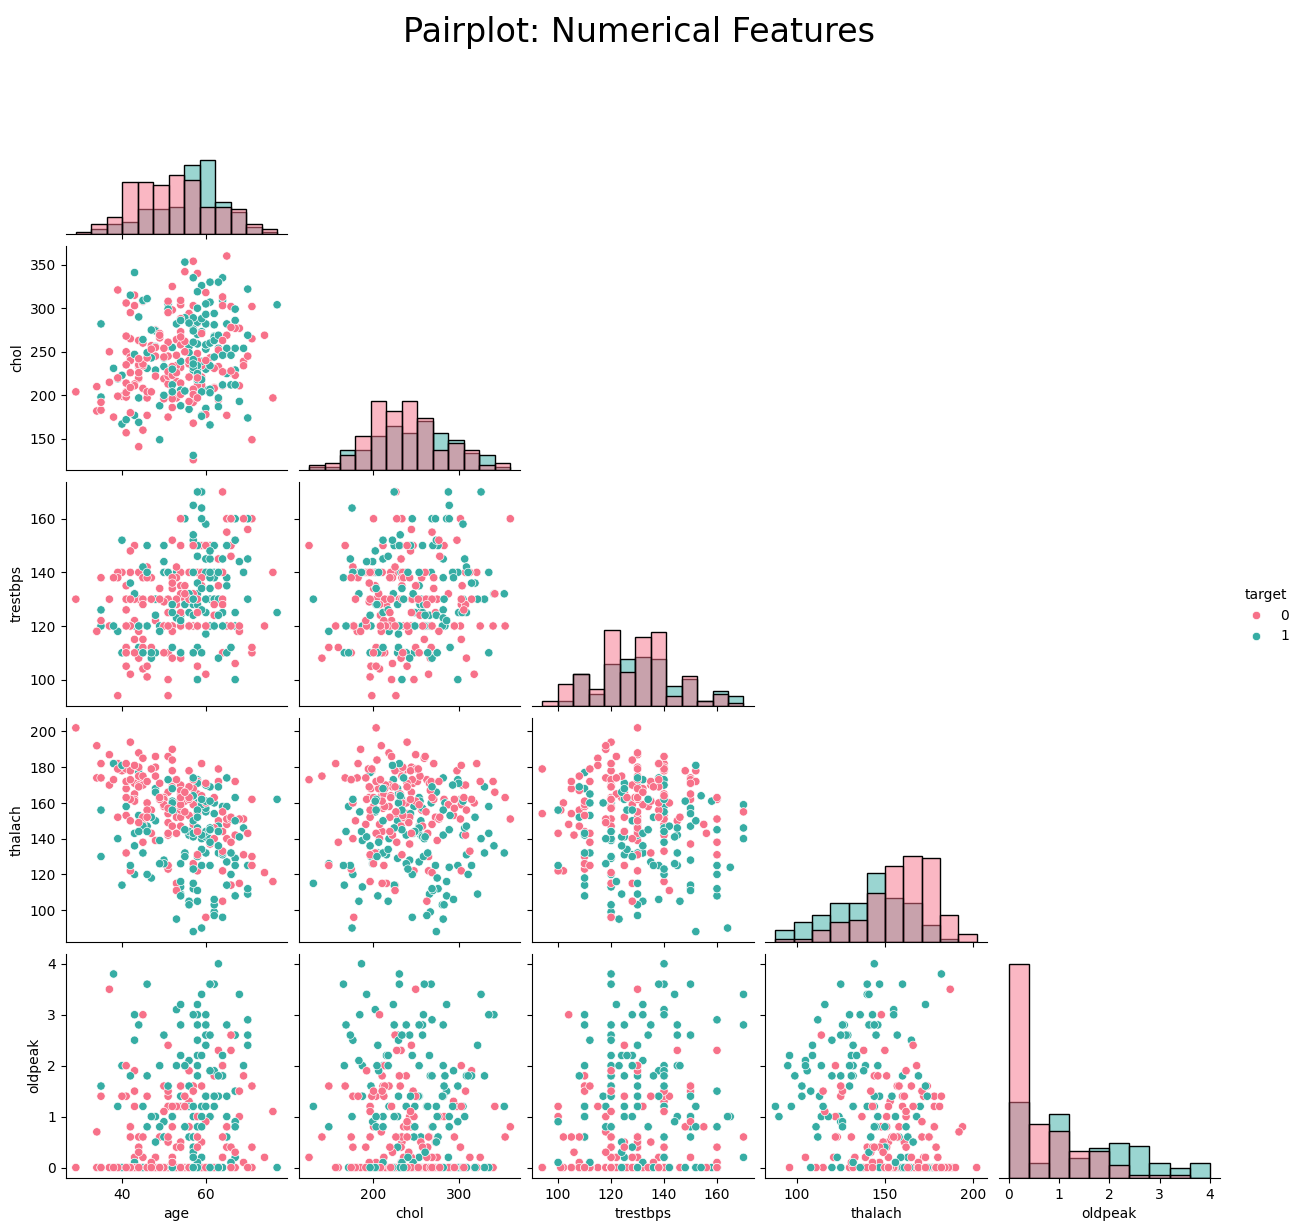

In [19]:

effective_features = ['age', 'chol', 'trestbps', 'thalach', 'oldpeak', 'target']
data = df[effective_features]
g = sns.pairplot(data, hue="target", corner=True, diag_kind='hist', palette='husl');
plt.suptitle('Pairplot: Numerical Features ' ,fontsize = 24);

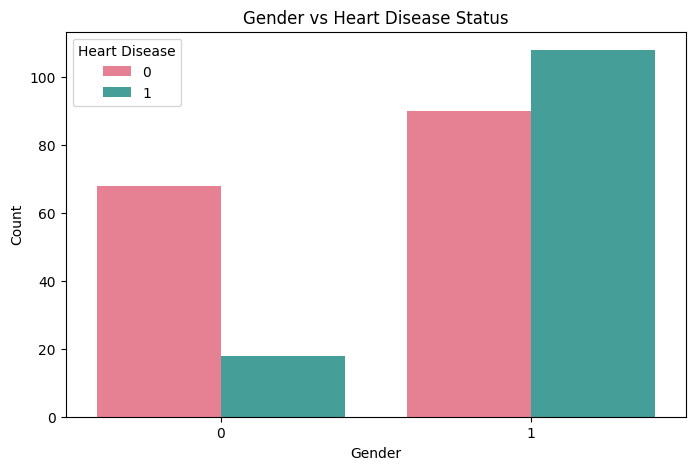

In [20]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sex', hue='target', palette='husl')
plt.title("Gender vs Heart Disease Status")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Heart Disease")
plt.show()

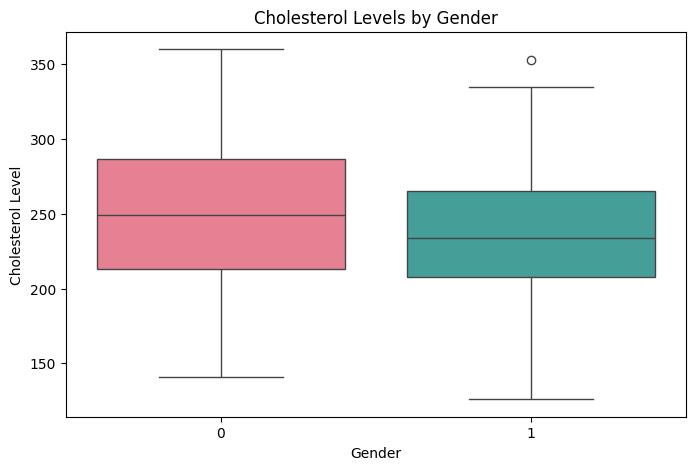

In [21]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='sex', y='chol', hue='sex', palette='husl', dodge=False, showfliers=True)
plt.title("Cholesterol Levels by Gender")
plt.xlabel("Gender")
plt.ylabel("Cholesterol Level")
plt.legend([],[], frameon=False)  # Hides the legend
plt.show()


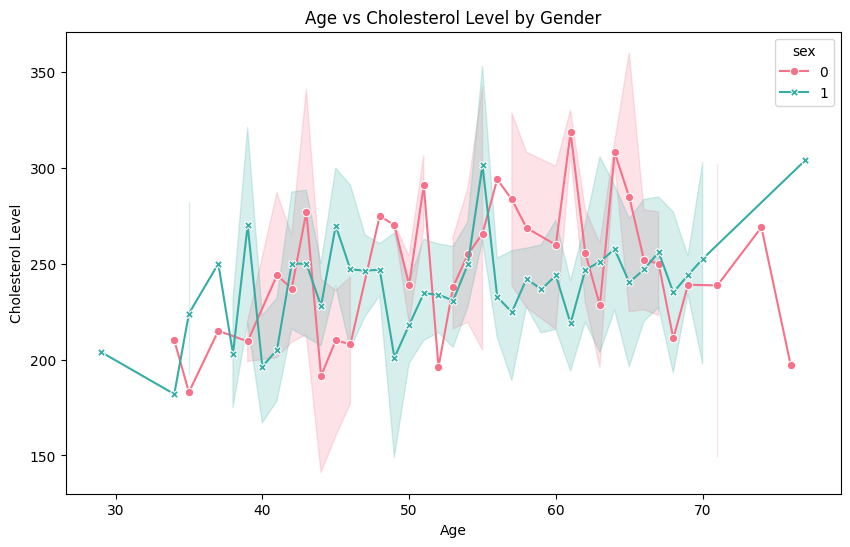

In [22]:
# Lineplot for Age and Cholesterol Level
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='age', y='chol', hue='sex', style='sex', markers=True, dashes=False, palette='husl')
plt.title("Age vs Cholesterol Level by Gender")
plt.xlabel("Age")
plt.ylabel("Cholesterol Level")
plt.show()

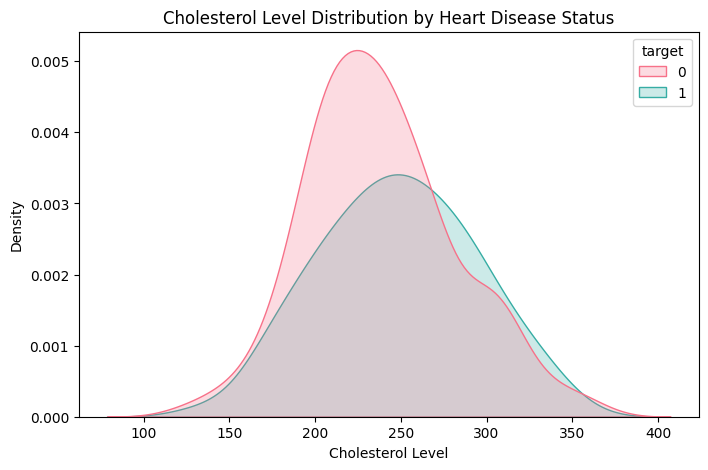

In [23]:
# KDE Plot for Cholesterol Levels
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='chol', hue='target', fill=True, palette='husl')
plt.title("Cholesterol Level Distribution by Heart Disease Status")
plt.xlabel("Cholesterol Level")
plt.ylabel("Density")
plt.show()

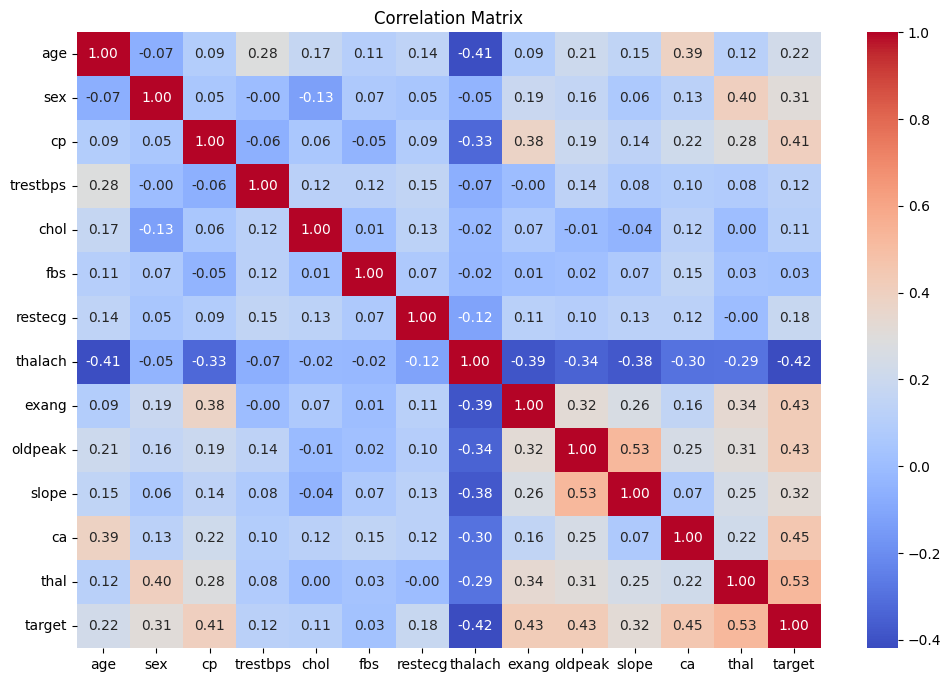

In [24]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [25]:

# Feature Scaling
scaler = MinMaxScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

#  Convert Target to Binary
# Assuming target > 0.5 indicates disease presence
if df['target'].dtype != 'int64' and df['target'].dtype != 'int32':
    df['target'] = (df['target'] > 0.5).astype(int)


In [26]:

#  Splitting Data
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:

#  Model Training and Evaluation
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)


print(f"Accuracy: {rf_accuracy:.2f}")
print(f"Precision: {rf_precision:.2f}")
print(f"Recall: {rf_recall:.2f}")

Accuracy: 0.88
Precision: 0.83
Recall: 0.87


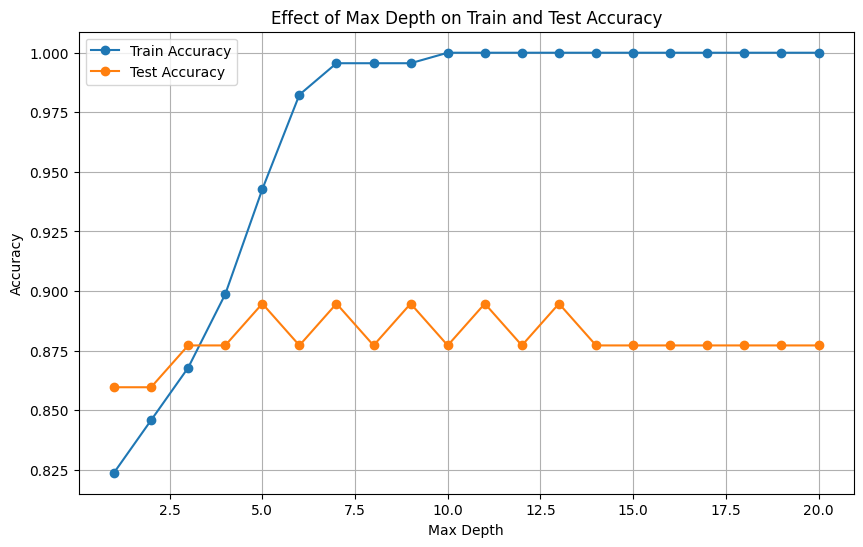

In [28]:
import matplotlib.pyplot as plt

# Lists to store accuracies for different max_depth values
train_accuracies = []
test_accuracies = []

# Range of max_depth values to test
max_depth_values = range(1, 21)

# Evaluate Random Forest model with different max_depth values
for max_depth in max_depth_values:
    rf_model = RandomForestClassifier(random_state=42, max_depth=max_depth)
    rf_model.fit(X_train, y_train)

    # Training accuracy
    train_accuracy = rf_model.score(X_train, y_train)
    train_accuracies.append(train_accuracy)

    # Testing accuracy
    test_accuracy = rf_model.score(X_test, y_test)
    test_accuracies.append(test_accuracy)

# Plotting train and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(max_depth_values, test_accuracies, label='Test Accuracy', marker='o')

# Adding labels and title
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Effect of Max Depth on Train and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)


print(f"Accuracy: {lr_accuracy:.2f}")
print(f"Precision: {lr_precision:.2f}")
print(f"Recall: {lr_recall:.2f}")




Accuracy: 0.88
Precision: 0.81
Recall: 0.91


In [30]:
# identifying most important feaures

rfe = RFE(lr_model, n_features_to_select=6)  # running RFE and specifying that the final selection should contain 6 features
rfe = rfe.fit(X_train, y_train)

important_feats = list(zip(X_train.columns,rfe.support_,rfe.ranking_))
important_feats = pd.DataFrame(important_feats, columns=['Features', 'Support', 'Ranking'])
print(important_feats)



cols = X_train.columns[rfe.support_] # identify the columns (or features) from the dataset X_train that were selected by the Recursive Feature Elimination (RFE) process.
print(cols)
X_train_rfe = X_train[cols]

    Features  Support  Ranking
0        age    False        8
1        sex    False        2
2         cp     True        1
3   trestbps    False        3
4       chol     True        1
5        fbs    False        7
6    restecg    False        5
7    thalach     True        1
8      exang    False        4
9    oldpeak     True        1
10     slope    False        6
11        ca     True        1
12      thal     True        1
Index(['cp', 'chol', 'thalach', 'oldpeak', 'ca', 'thal'], dtype='object')


In [31]:

# Adding a constant variable
import statsmodels.api as sm
X_train_rfe = sm.add_constant(X_train_rfe)

log_reg_model_rfe = sm.Logit(y_train, X_train_rfe).fit()
log_reg_model_rfe.summary()

Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  227
Model:                          Logit   Df Residuals:                      220
Method:                           MLE   Df Model:                            6
Date:                Mon, 27 Jan 2025   Pseudo R-squ.:                  0.4363
Time:                        09:37:44   Log-Likelihood:                -88.146
converged:                       True   LL-Null:                       -156.37
Covariance Type:            nonrobust   LLR p-value:                 5.617e-27
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6837      1.054     -3.494      0.000      -5.750      -1.618
cp             1.9751      0.587      3.364      0.001       0.824       3.126
chol           2.5862      1.067      2.425      0.015       0.496       4.677
thalach       -2.2695      1.116     -2.034      0.042      -4.457      -0.082
oldpeak        3.5600      0.880      4.047      0.000       1.836       5.284
ca             2.7670      0.747      3.705      0.000       1.303       4.231
thal           1.8349      0.407      4.512      0.000       1.038       2.632
==============================================================================
"""

In [32]:

# Support Vector Machine
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)


print(f"Accuracy: {svm_accuracy:.2f}")
print(f"Precision: {svm_precision:.2f}")
print(f"Recall: {svm_recall:.2f}")

Accuracy: 0.89
Precision: 0.84
Recall: 0.91


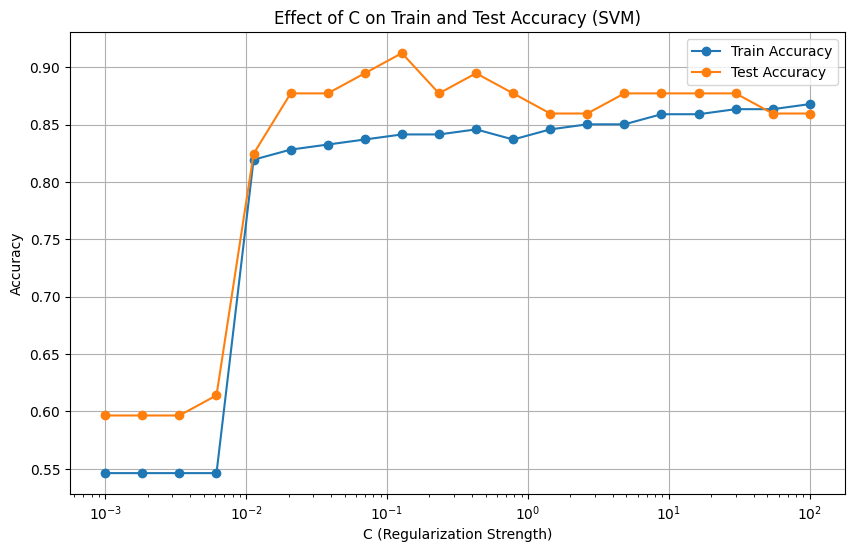

In [39]:


# Lists to store accuracies for different C values
train_accuracies = []
test_accuracies = []

# Range of C values to test (logarithmic scale for better coverage)
C_values = np.logspace(-3, 2, 20)

# Evaluate SVM model with different C values
for C in C_values:
    svm_model = SVC(kernel='linear', random_state=42, C=C)
    svm_model.fit(X_train, y_train)

    # Training accuracy
    train_accuracy = svm_model.score(X_train, y_train)
    train_accuracies.append(train_accuracy)

    # Testing accuracy
    test_accuracy = svm_model.score(X_test, y_test)
    test_accuracies.append(test_accuracy)

# Plotting train and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(C_values, test_accuracies, label='Test Accuracy', marker='o')

# Adding labels and title
plt.xscale('log')  # Use logarithmic scale for C values
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Effect of C on Train and Test Accuracy (SVM)')
plt.legend()
plt.grid(True)
plt.show()


In [34]:

# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)


print(f"Accuracy: {knn_accuracy:.2f}")
print(f"Precision: {knn_precision:.2f}")
print(f"Recall: {knn_recall:.2f}")

Accuracy: 0.81
Precision: 0.80
Recall: 0.70


In [35]:

# Naive Bayse
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
print('Print Predict')
print(nb_pred)
nb_prob = nb_model.predict_proba(X_test)[:, 1]
print('Print predict_proba')
print(nb_prob)
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_precision = precision_score(y_test, nb_pred)
nb_recall = recall_score(y_test, nb_pred)

print(f"Accuracy: {nb_accuracy:.2f}")
print(f"Precision: {nb_precision:.2f}")
print(f"Recall: {nb_recall:.2f}")

Print Predict
[1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 1
 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0]
Print predict_proba
[9.99961409e-01 9.64363589e-01 8.45872501e-01 3.62147136e-06
 1.68002206e-02 9.86077518e-01 2.82863901e-03 6.43565342e-01
 7.28226863e-02 3.64318392e-04 9.98725002e-01 6.28843527e-01
 1.34267716e-01 1.52157421e-01 2.15517930e-03 7.72792787e-04
 9.10983607e-01 1.26391759e-03 2.09893391e-03 4.11261537e-02
 9.98796424e-01 9.99999580e-01 1.39039793e-03 9.99996987e-01
 2.96342980e-01 9.95023617e-01 9.98373746e-01 7.66654311e-02
 3.80095121e-04 4.22094661e-03 9.93655558e-01 5.41367896e-03
 9.99842342e-01 3.15097411e-02 7.46572870e-03 8.35039101e-01
 9.99999212e-01 4.52202252e-03 9.97369253e-01 6.25804305e-04
 9.98521259e-01 9.99589888e-01 1.85889058e-03 5.24576807e-01
 8.28658188e-03 8.66906741e-01 3.15634789e-05 2.21661690e-03
 3.61270014e-04 3.41879302e-02 7.04937594e-03 9.99877756e-01
 9.98587327e-01 9.97916760e-01 2.84384421e-01 9.99975419

{'Random Forest': {'Accuracy': 0.8771929824561403, 'Precision': 0.8333333333333334, 'Recall': 0.8695652173913043, 'F1 Score': 0.851063829787234}, 'Logistic Regression': {'Accuracy': 0.8771929824561403, 'Precision': 0.8076923076923077, 'Recall': 0.9130434782608695, 'F1 Score': 0.8571428571428571}, 'SVM': {'Accuracy': 0.8947368421052632, 'Precision': 0.84, 'Recall': 0.9130434782608695, 'F1 Score': 0.875}, 'NB': {'Accuracy': 0.8771929824561403, 'Precision': 0.8076923076923077, 'Recall': 0.9130434782608695, 'F1 Score': 0.8571428571428571}, 'KNN': {'Accuracy': 0.8070175438596491, 'Precision': 0.8, 'Recall': 0.6956521739130435, 'F1 Score': 0.7441860465116279}}


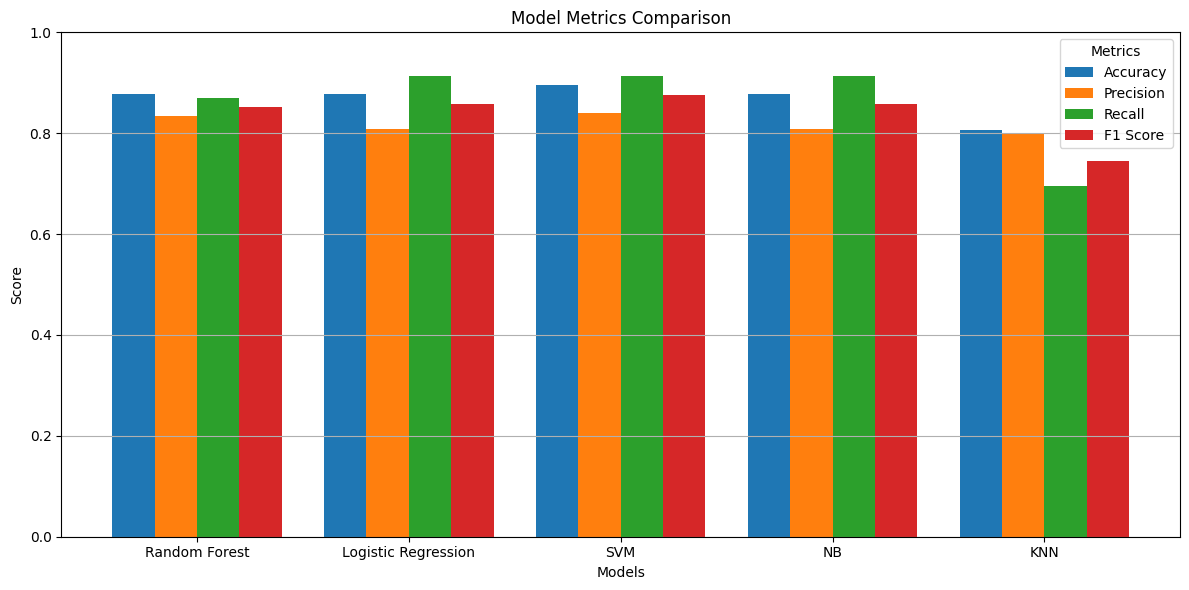


The best model for this dataset is: SVM


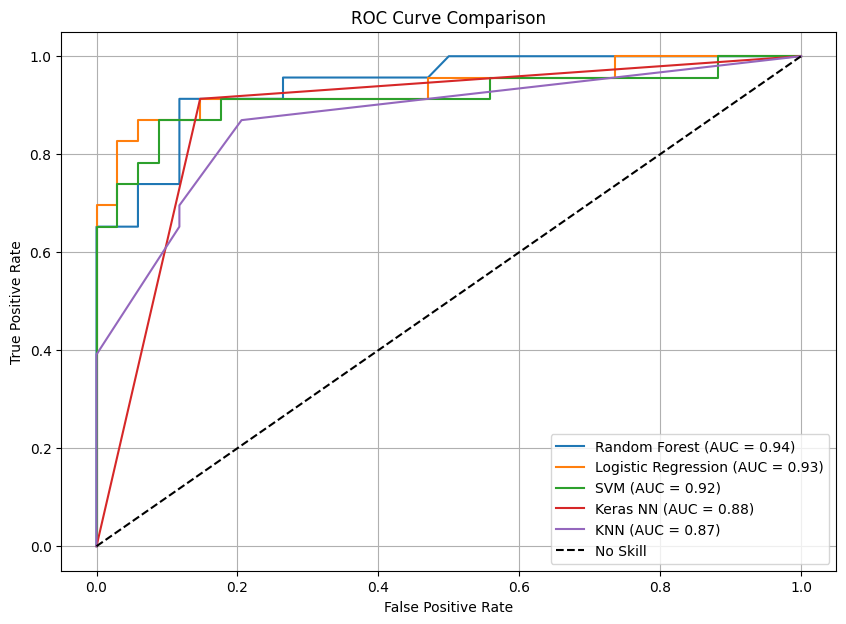


Classification Report For SVM :

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        34
           1       0.84      0.91      0.88        23

    accuracy                           0.89        57
   macro avg       0.89      0.90      0.89        57
weighted avg       0.90      0.89      0.90        57


Confusion Matrix:

[[30  4]
 [ 2 21]]


In [42]:


# Assuming you already have the predictions for each model
model_metrics = {
    "Random Forest": {
        "Accuracy": rf_accuracy,
        "Precision": rf_precision,
        "Recall": rf_recall,
        "F1 Score": f1_score(y_test, rf_pred)
    },
    "Logistic Regression": {
        "Accuracy": lr_accuracy,
        "Precision": lr_precision,
        "Recall": lr_recall,
        "F1 Score": f1_score(y_test, lr_pred)
    },
    "SVM": {
        "Accuracy": svm_accuracy,
        "Precision": svm_precision,
        "Recall": svm_recall,
        "F1 Score": f1_score(y_test, svm_pred)
    },
    "NB": {
        "Accuracy": nb_accuracy,
        "Precision": nb_precision,
        "Recall": nb_recall,
        "F1 Score": f1_score(y_test, nb_pred)
    },
    "KNN": {
        "Accuracy": knn_accuracy,
        "Precision": knn_precision,
        "Recall": knn_recall,
        "F1 Score": f1_score(y_test, knn_pred)
    }
}

print(model_metrics)
# Extract metrics for plotting
models = list(model_metrics.keys())
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
metric_values = {metric: [model_metrics[model][metric] for model in models] for metric in metrics}

# Plot grouped bar chart
x = np.arange(len(models))  # X positions for groups
bar_width = 0.2  # Width of each bar

plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, metric_values[metric], width=bar_width, label=metric)

# Add labels, title, and legend
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Model Metrics Comparison")
plt.xticks(x + bar_width * 1.5, models)  # Center group labels
plt.ylim(0, 1)
plt.legend(title="Metrics")
plt.grid(axis='y')

plt.tight_layout()
plt.show()


# Decide Best Model based on accuracy
best_model = max(model_metrics, key=lambda model: model_metrics[model]["Accuracy"])
print(f"\nThe best model for this dataset is: {best_model}")


# Collecting predicted probabilities for ROC Curve
rf_probs = rf_model.predict_proba(X_test)[:, 1]
log_reg_probs = lr_model.predict_proba(X_test)[:, 1]
svm_probs = svm_model.decision_function(X_test)
nb_probs = nb_model.predict(X_test).flatten()
knn_probs = knn_model.predict_proba(X_test)[:, 1]

# Calculate ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, log_reg_probs)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_probs)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probs)

# Plot all ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_rf, tpr_rf, label="Random Forest (AUC = {:.2f})".format(auc(fpr_rf, tpr_rf)))
plt.plot(fpr_log_reg, tpr_log_reg, label="Logistic Regression (AUC = {:.2f})".format(auc(fpr_log_reg, tpr_log_reg)))
plt.plot(fpr_svm, tpr_svm, label="SVM (AUC = {:.2f})".format(auc(fpr_svm, tpr_svm)))
plt.plot(fpr_nb, tpr_nb, label="Keras NN (AUC = {:.2f})".format(auc(fpr_nb, tpr_nb)))
plt.plot(fpr_knn, tpr_knn, label="KNN (AUC = {:.2f})".format(auc(fpr_knn, tpr_knn)))

plt.plot([0, 1], [0, 1], 'k--', label="No Skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Classification Report and Confusion Matrix for the Best Model
if best_model == "Random Forest":
    y_pred = rf_pred
elif best_model == "Logistic Regression":
    y_pred = lr_pred
elif best_model == "SVM":
    y_pred = svm_pred
elif best_model == "Keras NN":
    y_pred = nb_pred
else:
    y_pred = knn_pred

print("\nClassification Report For", best_model ,":\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


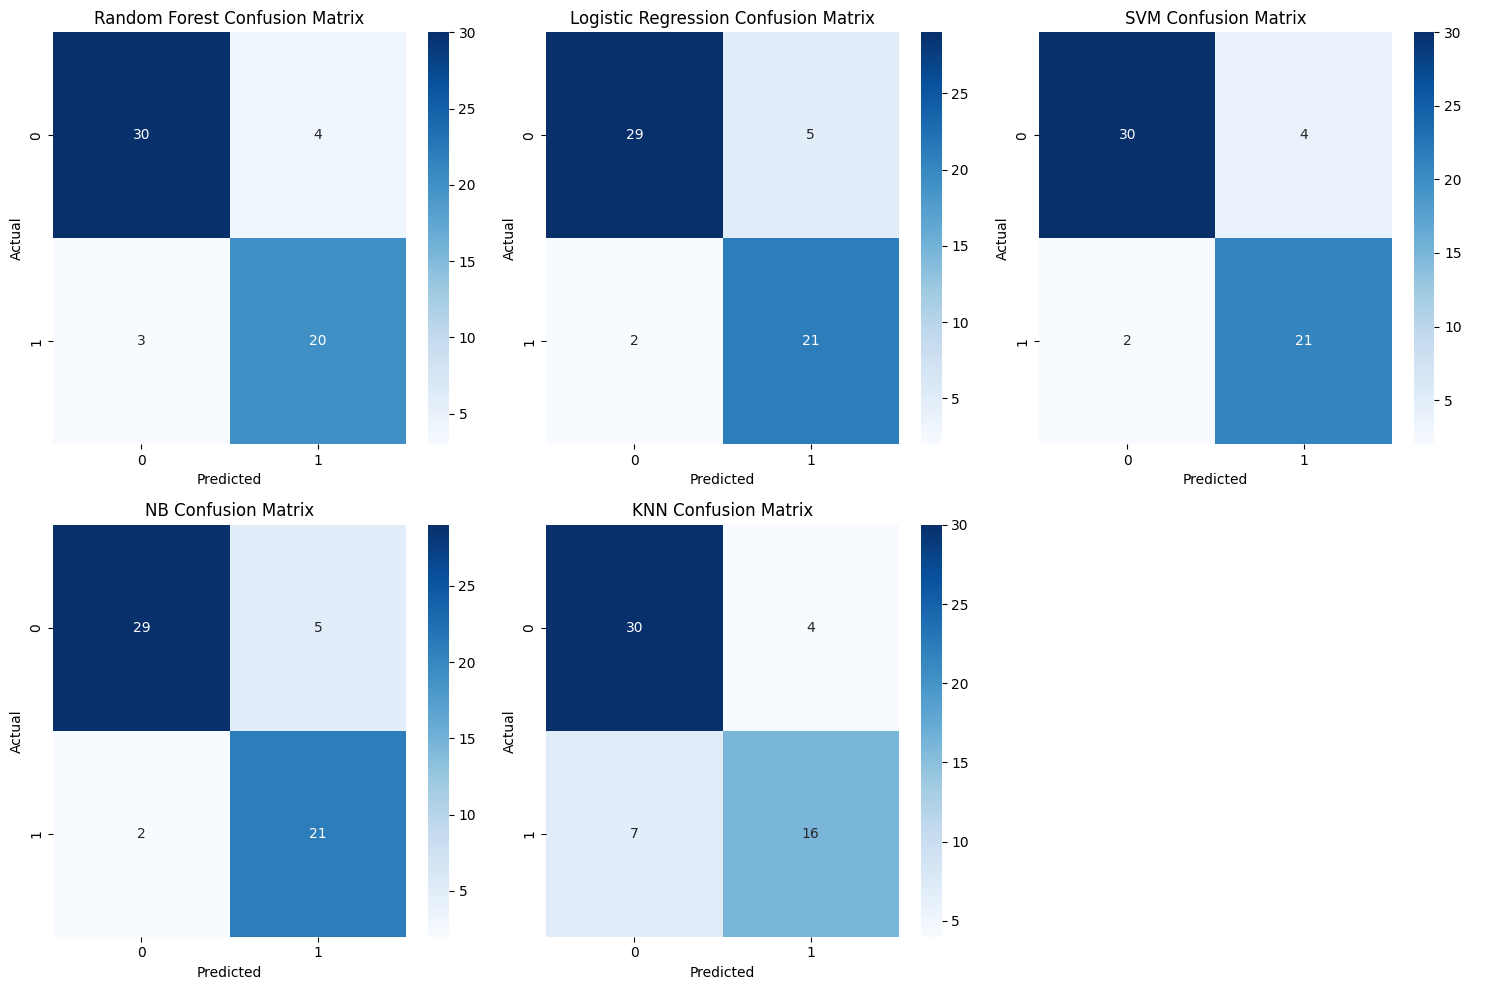

In [37]:


# Assuming you have the predictions for all models
model_predictions = {
    "Random Forest": rf_pred,
    "Logistic Regression": lr_pred,
    "SVM": svm_pred,
    "NB": nb_pred,
    "KNN": knn_pred
}

# Define number of rows and columns for the plot grid
rows = 2
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.ravel()  # Flatten the grid for easy iteration

# Plot each confusion matrix
for i, (model, predictions) in enumerate(model_predictions.items()):
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"{model} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

# Hide any unused subplots
for j in range(len(model_predictions), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
